# Paper Plots

In [3]:
import csv
import numpy as np
from scipy.constants import c
from lifelines import KaplanMeierFitter

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Load Data

In [4]:
with open('../tables/table2.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    data = np.array([row for row in reader]).T

obsnames = data[0]
z_list, fluxpeaks, fluxpeaks_err, ul_list, m1450_list, allwise_AB_list, allwise_err_list, spitzer_AB_list, spitzer_AB_err_list, Lsgn, log_L_nu_list, log_L_peak_list, log_L_peak_err_list, log_L_ul_list, log_L4400_list, log_L4400_err_list, R_list, Rerr_list, Rul_list = data[1:].astype(float)

In [5]:
i_det, i_ul = [], []

for i, (fp, fperr) in enumerate(zip(fluxpeaks, fluxpeaks_err)):
    if fp/fperr > 3:
        i_det.append(i)
    else:
        i_ul.append(i)

In [6]:
det_names = ["QSO-J0100+2802", "QSO-J1034-1425", "QSO-J1427+3312", "QSO-J1429+5447", "QSO-J1558-0724", "QSO-J1602+4228", "QSO-J2318-3113", "QSO-J2348-3054"]
i_det = np.where(np.in1d(obsnames, det_names))
i_ul = np.where(~np.in1d(obsnames, det_names))
print(obsnames[i_det], log_L4400_list[i_det])

['QSO-J0100+2802' 'QSO-J1034-1425' 'QSO-J1427+3312' 'QSO-J1429+5447'
 'QSO-J1558-0724' 'QSO-J1602+4228' 'QSO-J2318-3113' 'QSO-J2348-3054'] [13.73617509 13.14425741 12.75155171 12.69144247 13.11543843 13.11441422
 12.57543843 12.52257034]


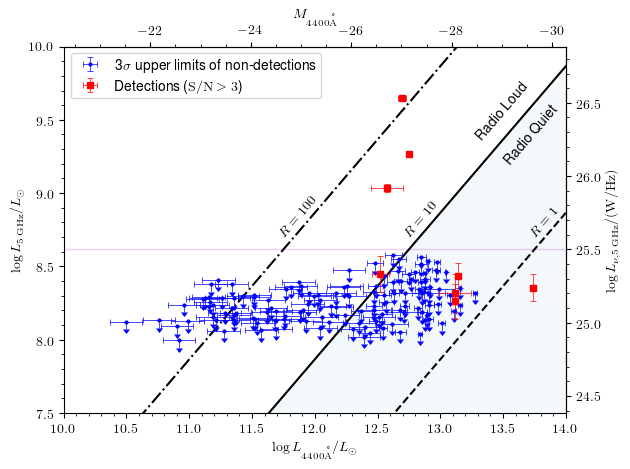

In [7]:
fig, ax1 = plt.subplots()

Lsol = 3.828e26
LtoLd = lambda x: x - np.log10(5e9 / Lsol)
LdtoL = lambda x: x + np.log10(5e9 / Lsol)

LtoM = lambda x: -2.5 * (x + np.log10(Lsol * 4.4e-7 / c)) + 34.1
MtoL = lambda x: (34.1 - (x - np.log10(Lsol * 4.4e-7 / c))) / 2.5

r1 = lambda x: (x + np.log10(4.4e-7 / c)) + np.log10(5e9)
r10 = lambda x: 1 + (x + np.log10(4.4e-7 / c)) + np.log10(5e9)
r100 = lambda x: 2 + (x + np.log10(4.4e-7 / c)) + np.log10(5e9)

x = np.linspace(10, 14, 100)

ax1.hlines(LdtoL(25.5), 10, 14, linewidth=1, alpha=0.2, color="m")
ax1.plot(x, r1(x), c="k", linestyle="--")
ax1.plot(x, r10(x), c="k", linestyle="-")
ax1.plot(x, r100(x), c="k", linestyle="-.")
ax1.fill_between(x, r10(x), alpha=0.05)

ax1.errorbar(log_L4400_list[i_ul], log_L_ul_list[i_ul], xerr=log_L4400_err_list[i_ul], yerr=0.05, fmt='.', color="b", capsize=2, capthick=.5, elinewidth=.5, ms=4, uplims=True, label=r"3$\sigma$ upper limits of non-detections")
ax1.errorbar(log_L4400_list[i_det], log_L_peak_list[i_det], xerr=log_L4400_err_list[i_det], yerr=log_L_peak_err_list[i_det], fmt='s', color="r", capsize=2, capthick=.5, elinewidth=.5, ms=4, label=r"Detections ($\mathrm{S/N}>3$)")
ax2 = ax1.secondary_yaxis("right", functions=(LtoLd, LdtoL))
ax3 = ax1.secondary_xaxis("top", functions=(LtoM, MtoL))

ax1.set_xlabel(r"$\log{L_{4400\mathrm{\AA}}} / L_{\odot}$")
ax1.set_ylabel(r"$\log{L_{5\,\mathrm{GHz}}} / L_{\odot}$")
ax2.set_ylabel(r"$\log{L_{\nu,5\,\mathrm{GHz}}} / (\mathrm{W/Hz})$")
ax3.set_xlabel(r"$M_{4400\mathrm{\AA}}$")

ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()

plt.text(11.7, 8.7, r"$R=100$", rotation=45, transform_rotates_text=True)
plt.text(12.7, 8.7, r"$R=10$", rotation=45, transform_rotates_text=True)
plt.text(13.7, 8.7, r"$R=1$", rotation=45, transform_rotates_text=True)
plt.text(13.27, 9.37, "Radio Loud", rotation=45, transform_rotates_text=True)
plt.text(13.5, 9.2, "Radio Quiet", rotation=45, transform_rotates_text=True)

plt.xlim([10, 14])
plt.ylim([7.5, 10])
plt.legend(loc=2)

plt.tight_layout()
plt.savefig("../../plots/R_plot.png", dpi=600)

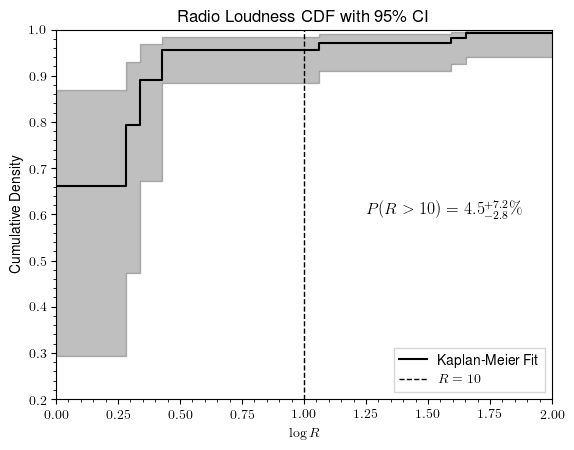

In [8]:
logR = np.log10(np.hstack([R_list[i_det], Rul_list[i_ul]]))
E = np.zeros_like(logR)
#E = logR < 1.0
E[:len(i_det[0])] = 1

kmf = KaplanMeierFitter()
res = kmf.fit_left_censoring(logR, E)

idx = np.argmin(np.abs(kmf.cumulative_density_['KM_estimate'].index - 1))
km, kml, kmu = (kmf.cumulative_density_['KM_estimate'].values[idx], kmf.confidence_interval_cumulative_density_['KM_estimate_lower_0.95'].values[idx], kmf.confidence_interval_cumulative_density_['KM_estimate_upper_0.95'].values[idx])

rlf = (1 - km) * 100
rlfu = np.abs(km - kml) * 100
rlfl = np.abs(km - kmu) * 100

kmf.plot_cumulative_density(label="Kaplan-Meier Fit", color="k", xlabel=r"$\log{R}$", ylabel="Cumulative Density")
plt.vlines(1, 0, 1, linestyle="--", color="k", linewidth=1, label=r"$R=10$")
plt.xlim([0.0, 2.0])
plt.ylim([0.2, 1.0])
plt.minorticks_on()
plt.title("Radio Loudness CDF with 95\% CI")
plt.legend(fancybox=False, loc=4)
plt.text(1.25, 0.6, r"$P(R>10)={%.1f}^{+%.1f}_{-%.1f} %s$" % (rlf.round(1), rlfu.round(1), rlfl.round(1), "\%"), fontsize=12)
plt.savefig("../../plots/kmr.pdf")

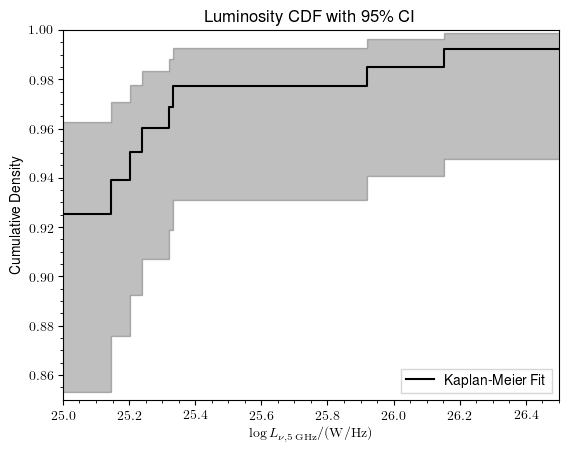

In [28]:
logL = LtoLd(np.hstack([log_L_peak_list[i_det], log_L_ul_list[i_ul]]))
E = np.zeros_like(logL)
E[:len(i_det[0])] = 1

kmf = KaplanMeierFitter()
res = kmf.fit_left_censoring(logL, E)

kmf.plot_cumulative_density(label="Kaplan-Meier Fit", color="k", xlabel=r"$\log{L_{\nu,5\,\mathrm{GHz}} / (\mathrm{W/Hz})}$", ylabel=r"Cumulative Density")
plt.xlim([25, 26.5])
plt.ylim([0.85, 1.0])
#plt.yscale("log")
plt.minorticks_on()
plt.title("Luminosity CDF with 95\% CI")
plt.legend(fancybox=False, loc=4)
plt.savefig("../../plots/kml.pdf")

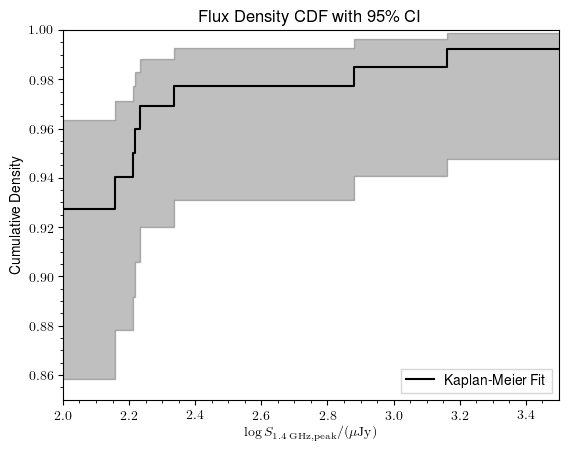

In [26]:
log_fluxpeaks = np.log10(np.hstack([fluxpeaks[i_det], ul_list[i_ul]]))
E = np.zeros_like(log_fluxpeaks)
E[:len(i_det[0])] = 1

kmf = KaplanMeierFitter()
res = kmf.fit_left_censoring(log_fluxpeaks, E)

kmf.plot_cumulative_density(label="Kaplan-Meier Fit", color="k", xlabel=r"$\log{S_{1.4\mathrm{\,GHz,peak}}/(\mu\mathrm{Jy})}$", ylabel=r"Cumulative Density")
plt.xlim([2, 3.5])
plt.ylim([0.85, 1.0])
plt.minorticks_on()
plt.title("Flux Density CDF with 95\% CI")
plt.legend(fancybox=False, loc=4)
plt.savefig("../../plots/kms.pdf")

In [68]:
print(f"Radio Loud Fraction: RLF = {rlf.round(1)} (+{rlfu.round(1)}, -{rlfl.round(1)})")

Radio Loud Fraction: RLF = 4.5 (+7.2, -2.8)
